# **Part1: Diffusion Models and Latent Diffusion**



In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Dec 17 11:32:01 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Section 1: Overview of Diffusion Models

Let's begin by seeing where diffusion models fit within the zoo of generative models in use today:

![model type diag](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/generative-overview.png)
Overview of different types of generative models. (from [this great blog post](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/))

The core concept behind these models is deceptively simple:
- Take a starting image
- Add some noise, iteratively degrading the image until almost nothing but noise remains.
- Train a model to 'undo' these noise steps.
- To generate, start from pure noise and repeatedly apply the model to 'denoise' our way back to a plausible image.

The model generally has access to some representation of 't' - that is, how many noise steps have been applied to the image. And to make its job easier, we typically get the model to output a prediction for the *noise* that we could subtract from the noisy image to get a less noisy one, rather than spitting out the denoised image.

With this high-level idea in our heads, let's have a go at implementing one!


# Section 2: Implementing One



In [ ]:
# @title Install requirements
!pip install datasets &>> install.log

In [ ]:
#@title imports and utility functions
from datasets import load_dataset
from PIL import Image
import torch.nn.functional as F
import os
from tqdm.notebook import tqdm
import torch
import numpy as np
import torchvision

def img_to_tensor(im):
  return torch.tensor(np.array(im.convert('RGB'))/255).permute(2, 0, 1).unsqueeze(0) * 2 - 1

def tensor_to_image(t):
  return Image.fromarray(np.array(((t.squeeze().permute(1, 2, 0)+1)/2).clip(0, 1)*255).astype(np.uint8))

def gather(consts: torch.Tensor, t: torch.Tensor):
    """Gather consts for $t$ and reshape to feature map shape"""
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)

In [ ]:
from google.colab import drive

In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
#@title configs

root_dir = '/content/drive/My Drive/diffusion/'
config_dir = '/content/drive/My Drive/diffusion/configs/'
fig_dir = '/content/drive/My Drive/diffusion/figs/'

# Training params
n_steps = 1000
batch_size = 256
lr = 2e-4 # Explore this - might want it lower when training on the full dataset
num_epochs = 70
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# os.makedirs(root_dir , exist_ok=True)
# os.makedirs(config_dir, exist_ok=True)
# os.makedirs(fig_dir, exist_ok=True)

## 2.1 Dataset

We'll start with a classic small dataset, with 32px square images from 10 classes. For convenience we just pull a version that is avalable on the huggingface hub.

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

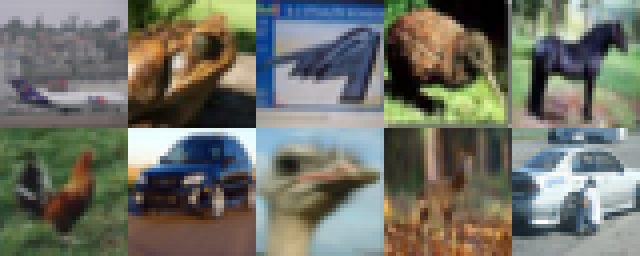

In [ ]:
#@title cifar10 - 32px images in 10 classes

# Download and load the dataset
cifar10 = load_dataset('cifar10')

# View some examples:
image = Image.new('RGB', size=(32*5, 32*2))
for i in range(10):
  im = cifar10['train'][i]['img']
  image.paste(im, ( (i%5)*32, (i//5)*32 ))
image.resize((32*5*4, 32*2*4), Image.NEAREST)

In [ ]:
preprocess =  torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                # torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
            ])
train_loader = torch.utils.data.DataLoader(
            torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=preprocess),
            batch_size=batch_size,
            shuffle=True,
            num_workers =2,
            drop_last=True
            )
test_loader = torch.utils.data.DataLoader(
            torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocess),
            batch_size=batch_size,
            shuffle=True,
            num_workers =2,
            drop_last=True
            )


100%|██████████| 170498071/170498071 [00:03<00:00, 49202347.28it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# @title alternative dataset: faces (CelebA) - uncomment to run
# faces = load_dataset('huggan/CelebA-faces')

## 2.2 Adding Noise

First, we want to define the spet that adds a little bit of noise - $q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$:

![process](https://datasciencecastnethome.files.wordpress.com/2022/04/screenshot-from-2022-04-12-14-55-09.png) [(Image source)](https://hojonathanho.github.io/diffusion/)

We set up a 'variance schedule' β, where beta[t] ($\beta_t$)specifies how much noise we want to add at that step. You get fancy schedules but we'll stick with a linear one for now. The formula you'll see for this single noise step is:

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$

We mix $\mathbf{x}_{t-1}$ with some gaussian noise, with how much noise decided by $\beta_t$. Let's see this in code and try applying it a bunch of times to an image:

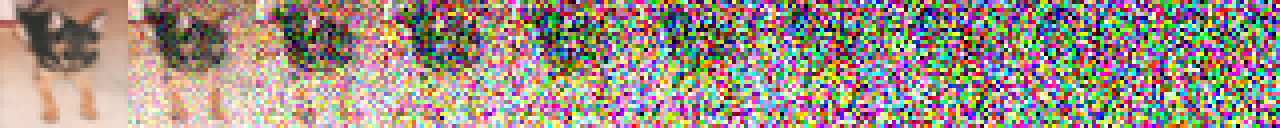

In [ ]:
beta = torch.linspace(0.0001, 0.04, n_steps)

def q_xt_xtminus1(xtm1, t):
  ################################################################################
    # TODO: complete the code here
    # Complete this function using the equation above to generate noise
    mean = gather(1. - beta, t) ** 0.5 * xtm1 # √(1−βt)*xtm1
    var = gather(beta, t) # βt I
    eps = torch.randn_like(xtm1) # Noise shaped like xtm1
    return mean + torch.sqrt(var)*eps

    # End
    ################################################################################

# Show im at different stages
ims = []
start_im = cifar10['train'][10]['img']
x = img_to_tensor(start_im).squeeze()
for t in range(n_steps):

  # Store images every 20 steps to show progression
  if t%20 == 0:
    ims.append(tensor_to_image(x))

  # Calculate Xt given Xt-1 (i.e. x from the previous iteration)
  t = torch.tensor(t, dtype=torch.long) # t as a tensor
  x = q_xt_xtminus1(x, t) # Modify x using our function above

# Display the images
image = Image.new('RGB', size=(32*10, 32))
for i, im in enumerate(ims):
  image.paste(im, ((i%10)*32, 0))
image.resize((32*4*10, 32*4), Image.NEAREST)

Now, we want to train our model at different time steps and we don't particulary want to iterativly add little bits of noise a bunch of times just to train one sample from t=37.

Luckily, some smart people did some fancy maths (link https://lilianweng.github.io/posts/2018-08-12-vae/#reparameterization-trick) using something called the reparameterization trick that lets us get $x_t$ for any t given $x_0$.

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$


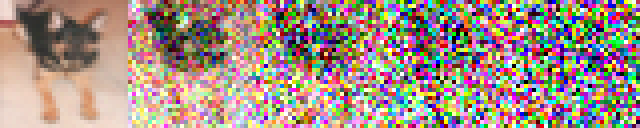

In [ ]:
# n_steps = 1000
beta = torch.linspace(0.0001, 0.04, n_steps)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

def q_xt_x0(x0, t):
  ################################################################################
    # TODO: complete the code here
    # Complete this function using the equation above to generate the appropriate noise
  mean = gather(alpha_bar, t) ** 0.5 * x0 # now alpha_bar
  var = 1-gather(alpha_bar, t) # (1-alpha_bar)
  eps = torch.randn_like(x0)
  return mean + (var ** 0.5) * eps

  # End
  ################################################################################

# Show im at different stages
ims = []
start_im = cifar10['train'][10]['img']
x0 = img_to_tensor(start_im).squeeze()
for t in range(n_steps):
  # Store images every 20 steps to show progression
  if t%40 == 0:
    x = q_xt_x0(x0, torch.tensor(t, dtype=torch.long)) # TODO move type to gather
    ims.append(tensor_to_image(x))

image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

Note the difference: we can now calculate xt without having to do `for t in range...`.

## 2.3 UNETs

So what model do we use to do this magical 'denoising' step? We've looked a little at basic convolutional neural networks that take in an image and output something like a classification. And we've seen autoencoders that go from an image down to a latent representation and back to an output image. Perhaps one of these would be suitable?

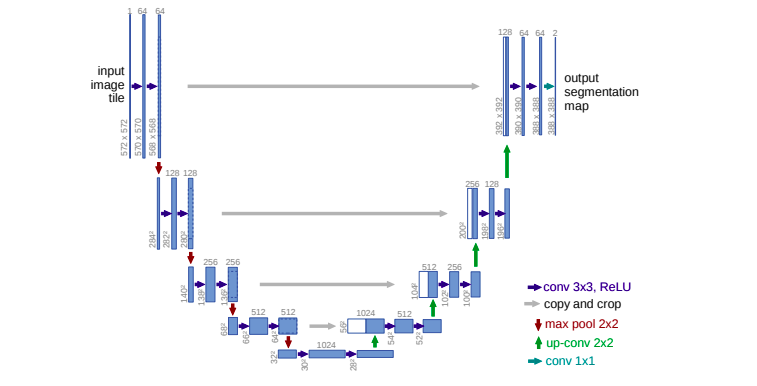

(Unet diagram from [the 2015 paper](https://arxiv.org/abs/1505.04597))

One issue with a typical 'bottlekneck' architecture like an autoencoder is that by design they loose the details around exact pixel coordinates. To get around this, an architecture called the Unet was introduced. Originally designed for segmentation tasks, the architecture (shown above) passes information from high-resolution, early layers to later layers. These 'shortcuts' let the network use detailed features from the original image while also capturing more high-level semantic information from the deeper layers.

These networks turned out to be great at all sorts of image-to-image tasks. Colorization ([deoldify](https://github.com/jantic/DeOldify)), segmentation and so on. These days, typical unet models incorporate ideas such as attention (it's all you need!) and can be built around pretrained 'backbones' like resnet-50 for transfer learning tasks.

The implementation below (taken almost verbatim from [here](https://github.com/labmlai/annotated_deep_learning_paper_implementations/blob/master/labml_nn/diffusion/ddpm/unet.py)) is a fairly typical modern Unet with one extra trick: a TimeEmbedding which encodes the time step (t) and lets the model use this as conditioning information by passing it in in the middle of the network. Take a peek at the code and see if you can figure out roughly what's going on in the forward pass.



In [ ]:
#@title Unet Definition

import math
from typing import Optional, Tuple, Union, List

import torch
from torch import nn

# A fancy activation function
class Swish(nn.Module):
    """
    ### Swish actiavation function
    $$x \cdot \sigma(x)$$
    """

    def forward(self, x):
        return x * torch.sigmoid(x)

# The time embedding
class TimeEmbedding(nn.Module):
    """
    ### Embeddings for $t$
    """

    def __init__(self, n_channels: int):
        """
        * `n_channels` is the number of dimensions in the embedding
        """
        super().__init__()
        self.n_channels = n_channels
        # First linear layer
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        # Activation
        self.act = Swish()
        # Second linear layer
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):
        # Create sinusoidal position embeddings

        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)

        # Transform with the MLP
        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)

        #
        return emb

# Residual blocks include 'skip' connections
class ResidualBlock(nn.Module):
    """
    ### Residual block
    A residual block has two convolution layers with group normalization.
    Each resolution is processed with two residual blocks.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, n_groups: int = 32):
        """
        * `in_channels` is the number of input channels
        * `out_channels` is the number of input channels
        * `time_channels` is the number channels in the time step ($t$) embeddings
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        """
        super().__init__()
        # Group normalization and the first convolution layer
        self.norm1 = nn.GroupNorm(n_groups, in_channels)
        self.act1 = Swish()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # Group normalization and the second convolution layer
        self.norm2 = nn.GroupNorm(n_groups, out_channels)
        self.act2 = Swish()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # If the number of input channels is not equal to the number of output channels we have to
        # project the shortcut connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))
        else:
            self.shortcut = nn.Identity()

        # Linear layer for time embeddings
        self.time_emb = nn.Linear(time_channels, out_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # First convolution layer
        h = self.conv1(self.act1(self.norm1(x)))
        # Add time embeddings
        h += self.time_emb(t)[:, :, None, None]
        # Second convolution layer
        h = self.conv2(self.act2(self.norm2(h)))

        # Add the shortcut connection and return
        return h + self.shortcut(x)

# Ahh yes, magical attention...
class AttentionBlock(nn.Module):
    """
    ### Attention block
    This is similar to [transformer multi-head attention](../../transformers/mha.html).
    """

    def __init__(self, n_channels: int, n_heads: int = 1, d_k: int = None, n_groups: int = 32):
        """
        * `n_channels` is the number of channels in the input
        * `n_heads` is the number of heads in multi-head attention
        * `d_k` is the number of dimensions in each head
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        """
        super().__init__()

        # Default `d_k`
        if d_k is None:
            d_k = n_channels
        # Normalization layer
        self.norm = nn.GroupNorm(n_groups, n_channels)
        # Projections for query, key and values
        self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
        # Linear layer for final transformation
        self.output = nn.Linear(n_heads * d_k, n_channels)
        # Scale for dot-product attention
        self.scale = d_k ** -0.5
        #
        self.n_heads = n_heads
        self.d_k = d_k

    def forward(self, x: torch.Tensor, t: Optional[torch.Tensor] = None):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        # Get shape
        batch_size, n_channels, height, width = x.shape
        # Change `x` to shape `[batch_size, seq, n_channels]`
        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)
        # Get query, key, and values (concatenated) and shape it to `[batch_size, seq, n_heads, 3 * d_k]`
        qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)
        # Split query, key, and values. Each of them will have shape `[batch_size, seq, n_heads, d_k]`
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        # Calculate scaled dot-product $\frac{Q K^\top}{\sqrt{d_k}}$
        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        # Softmax along the sequence dimension $\underset{seq}{softmax}\Bigg(\frac{Q K^\top}{\sqrt{d_k}}\Bigg)$
        attn = attn.softmax(dim=1)
        # Multiply by values
        res = torch.einsum('bijh,bjhd->bihd', attn, v)
        # Reshape to `[batch_size, seq, n_heads * d_k]`
        res = res.view(batch_size, -1, self.n_heads * self.d_k)
        # Transform to `[batch_size, seq, n_channels]`
        res = self.output(res)

        # Add skip connection
        res += x

        # Change to shape `[batch_size, in_channels, height, width]`
        res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)

        #
        return res


class DownBlock(nn.Module):
    """
    ### Down block
    This combines `ResidualBlock` and `AttentionBlock`. These are used in the first half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class UpBlock(nn.Module):
    """
    ### Up block
    This combines `ResidualBlock` and `AttentionBlock`. These are used in the second half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        # The input has `in_channels + out_channels` because we concatenate the output of the same resolution
        # from the first half of the U-Net
        self.res = ResidualBlock(in_channels + out_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class MiddleBlock(nn.Module):
    """
    ### Middle block
    It combines a `ResidualBlock`, `AttentionBlock`, followed by another `ResidualBlock`.
    This block is applied at the lowest resolution of the U-Net.
    """

    def __init__(self, n_channels: int, time_channels: int):
        super().__init__()
        self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
        self.attn = AttentionBlock(n_channels)
        self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res1(x, t)
        x = self.attn(x)
        x = self.res2(x, t)
        return x


class Upsample(nn.Module):
    """
    ### Scale up the feature map by $2 \times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)


class Downsample(nn.Module):
    """
    ### Scale down the feature map by $\frac{1}{2} \times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)

# The core class definition (aka the important bit)
class UNet(nn.Module):
    """
    ## U-Net
    """

    def __init__(self, image_channels: int = 3, n_channels: int = 64,
                 ch_mults: Union[Tuple[int, ...], List[int]] = (1, 2, 2, 4),
                 is_attn: Union[Tuple[bool, ...], List[int]] = (False, False, True, True),
                 n_blocks: int = 2):
        """
        * `image_channels` is the number of channels in the image. $3$ for RGB.
        * `n_channels` is number of channels in the initial feature map that we transform the image into
        * `ch_mults` is the list of channel numbers at each resolution. The number of channels is `ch_mults[i] * n_channels`
        * `is_attn` is a list of booleans that indicate whether to use attention at each resolution
        * `n_blocks` is the number of `UpDownBlocks` at each resolution
        """
        super().__init__()

        # Number of resolutions
        n_resolutions = len(ch_mults)

        # Project image into feature map
        self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))

        # Time embedding layer. Time embedding has `n_channels * 4` channels
        self.time_emb = TimeEmbedding(n_channels * 4)

        # #### First half of U-Net - decreasing resolution
        down = []
        # Number of channels
        out_channels = in_channels = n_channels
        # For each resolution
        for i in range(n_resolutions):
            # Number of output channels at this resolution
            out_channels = in_channels * ch_mults[i]
            # Add `n_blocks`
            for _ in range(n_blocks):
                down.append(DownBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
                in_channels = out_channels
            # Down sample at all resolutions except the last
            if i < n_resolutions - 1:
                down.append(Downsample(in_channels))

        # Combine the set of modules
        self.down = nn.ModuleList(down)

        # Middle block
        self.middle = MiddleBlock(out_channels, n_channels * 4, )

        # #### Second half of U-Net - increasing resolution
        up = []
        # Number of channels
        in_channels = out_channels
        # For each resolution
        for i in reversed(range(n_resolutions)):
            # `n_blocks` at the same resolution
            out_channels = in_channels
            for _ in range(n_blocks):
                up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            # Final block to reduce the number of channels
            out_channels = in_channels // ch_mults[i]
            up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            in_channels = out_channels
            # Up sample at all resolutions except last
            if i > 0:
                up.append(Upsample(in_channels))

        # Combine the set of modules
        self.up = nn.ModuleList(up)

        # Final normalization and convolution layer
        self.norm = nn.GroupNorm(8, n_channels)
        self.act = Swish()
        self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size]`
        """

        # Get time-step embeddings
        t = self.time_emb(t)

        # Get image projection
        x = self.image_proj(x)

        # `h` will store outputs at each resolution for skip connection
        h = [x]
        # First half of U-Net
        for m in self.down:
            x = m(x, t)
            h.append(x)

        # Middle (bottom)
        x = self.middle(x, t)

        # Second half of U-Net
        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, t)
            else:
                # Get the skip connection from first half of U-Net and concatenate
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                #
                x = m(x, t)

        # Final normalization and convolution
        return self.final(self.act(self.norm(x)))

In [ ]:
# Let's see it in action on dummy data:

# A dummy batch of 10 3-channel 32px images
x = torch.randn(10, 3, 32, 32)

# 't' - what timestep are we on
t = torch.tensor([50.], dtype=torch.long)

# Define the unet model
unet = UNet()

# The foreward pass (takes both x and t)
model_output = unet(x, t)

# The output shape matches the input.
model_output.shape

torch.Size([10, 3, 32, 32])

## 2.4 Training Time

Now that we have our 'diffusion model' defined, we need to train it to predict the noise given $x_t$ and $t$.

Why not predict the denoised image directly? Mostly just due to convenience - the noise is nicely scaled with a mean of zero, and this well-suited to being modeled with a neural network. You don't **have** to do it this way, but the papers do, and we can make it easy by tweaking our `q_xt_x0` function to return both the noised image ($x_t$) and the noise itself, which will be the 'target' our network tries to produce.

This training loop should look familiar from all the past lessons!

In [ ]:
# Create the model
unet = UNet(n_channels=32).to(device)

# Set up some parameters
beta = torch.linspace(0.0001, 0.04, n_steps).to(device)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

# Modified to return the noise itself as well
def q_xt_x0(x0, t):
################################################################################
    # TODO: complete the code here
    # Write the equation that you have witen in the previous section here again
    # This time write it based on what you want from it in the training process
  # print('x0' , x0.shape)
  # print('alpha_bar' , alpha_bar.shape)
  # print('t' , t.shape)
  mean = gather(alpha_bar, t) ** 0.5 * x0
  var = 1-gather(alpha_bar, t)
  eps = torch.randn_like(x0).to(x0.device)
  return mean + (var ** 0.5) * eps, eps # also returns noise


    # End
################################################################################



################################################################################
    # TODO: complete the code here
    # Define the relevant Optimizer to train your model
optim = torch.optim.AdamW(unet.parameters(), lr=lr) # Optimizer

# scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=20, gamma=0.9)

    # End
################################################################################



In [ ]:
# Training Loop

################################################################################
    # TODO: complete the code here
    # Write the main and forward training loop here
best_model_params_path = os.path.join(config_dir, 'best_diffusion_params.pt')
best_loss = np.inf
losses = [] # Store losses for later plotting
epoch_losses = [] # Store losses for later plotting

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 20)

    running_loss = 0.0
    train_loop = tqdm(enumerate(train_loader, 1), total=len(train_loader), desc="training", position=0, leave=True)
    for index,(x0, _) in train_loop:

        x0 = x0.to(device)
        t = torch.randint(0, n_steps, (batch_size,), dtype=torch.long).to(device) # Random 't's

        xt, noise = q_xt_x0(x0, t) # Get the noised images (xt) and the noise (our target)
        pred_noise = unet(xt.float(), t) # Run xt through the network to get its predictions
        loss = F.mse_loss(noise.float(), pred_noise) # Compare the predictions with the targets

        optim.zero_grad() # Zero the gradients
        loss.backward() # Backpropagate the loss (computes and store gradients)
        optim.step() # Update the network parameters (using those gradients)

        losses.append(loss.item())
        running_loss += loss.item()

        train_loop.set_description(f"train - epoch : {epoch}")
        train_loop.set_postfix(loss="{}".format(loss),
                              refresh=True,)

    epoch_loss = running_loss / len(train_loader)
    epoch_losses.append(epoch_loss)
    lr = optim.state_dict()['param_groups'][0]['lr']
    print(f'Epoch Loss: {epoch_loss:.4f} LR: { lr }')

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        print("Saving best model with loss: " , best_loss)
        state_dict = dict()
        state_dict["model"] = unet.state_dict()
        state_dict["optimizer"] = optim.state_dict()
        torch.save(state_dict, best_model_params_path)

    # scheduler.step()


    # End
################################################################################

Epoch 0/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.1850 LR: 0.0002
Saving best model with loss:  0.1849781895104127
Epoch 1/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0477 LR: 0.0002
Saving best model with loss:  0.04765883502669824
Epoch 2/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0336 LR: 0.0002
Saving best model with loss:  0.03355824172687836
Epoch 3/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0270 LR: 0.0002
Saving best model with loss:  0.027039961707897676
Epoch 4/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0241 LR: 0.0002
Saving best model with loss:  0.024054225486440536
Epoch 5/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0228 LR: 0.0002
Saving best model with loss:  0.02277275451864952
Epoch 6/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0213 LR: 0.0002
Saving best model with loss:  0.02134105559820548
Epoch 7/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0201 LR: 0.0002
Saving best model with loss:  0.020082195919866746
Epoch 8/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0195 LR: 0.0002
Saving best model with loss:  0.019468556239436833
Epoch 9/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0190 LR: 0.0002
Saving best model with loss:  0.01895183155265374
Epoch 10/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0178 LR: 0.0002
Saving best model with loss:  0.01783490302757575
Epoch 11/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0177 LR: 0.0002
Saving best model with loss:  0.01765395358013801
Epoch 12/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0175 LR: 0.0002
Saving best model with loss:  0.017465994062905128
Epoch 13/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0167 LR: 0.0002
Saving best model with loss:  0.016662277849629904
Epoch 14/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0165 LR: 0.0002
Saving best model with loss:  0.016521353231599697
Epoch 15/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0164 LR: 0.0002
Saving best model with loss:  0.01644758480386092
Epoch 16/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0163 LR: 0.0002
Saving best model with loss:  0.016258022848230143
Epoch 17/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0162 LR: 0.0002
Saving best model with loss:  0.016179227523314646
Epoch 18/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0156 LR: 0.0002
Saving best model with loss:  0.01564469146900452
Epoch 19/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0157 LR: 0.0002
Epoch 20/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0156 LR: 0.0002
Saving best model with loss:  0.015566268076117221
Epoch 21/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0156 LR: 0.0002
Epoch 22/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0154 LR: 0.0002
Saving best model with loss:  0.01535456944257021
Epoch 23/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0153 LR: 0.0002
Saving best model with loss:  0.01525573348865295
Epoch 24/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0149 LR: 0.0002
Saving best model with loss:  0.014864670948531384
Epoch 25/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0150 LR: 0.0002
Epoch 26/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0150 LR: 0.0002
Epoch 27/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0150 LR: 0.0002
Epoch 28/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0147 LR: 0.0002
Saving best model with loss:  0.014700256101787091
Epoch 29/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0150 LR: 0.0002
Epoch 30/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0146 LR: 0.0002
Saving best model with loss:  0.014599019647217715
Epoch 31/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0146 LR: 0.0002
Saving best model with loss:  0.014568615026580982
Epoch 32/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0143 LR: 0.0002
Saving best model with loss:  0.014329212316526816
Epoch 33/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0240 LR: 0.0002
Epoch 34/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0200 LR: 0.0002
Epoch 35/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0187 LR: 0.0002
Epoch 36/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0180 LR: 0.0002
Epoch 37/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0182 LR: 0.0002
Epoch 38/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0173 LR: 0.0002
Epoch 39/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0173 LR: 0.0002
Epoch 40/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0172 LR: 0.0002
Epoch 41/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0175 LR: 0.0002
Epoch 42/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0178 LR: 0.0002
Epoch 43/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0176 LR: 0.0002
Epoch 44/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0176 LR: 0.0002
Epoch 45/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0234 LR: 0.0002
Epoch 46/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0179 LR: 0.0002
Epoch 47/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0175 LR: 0.0002
Epoch 48/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0174 LR: 0.0002
Epoch 49/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0173 LR: 0.0002
Epoch 50/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0167 LR: 0.0002
Epoch 51/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0202 LR: 0.0002
Epoch 52/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0170 LR: 0.0002
Epoch 53/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0172 LR: 0.0002
Epoch 54/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0170 LR: 0.0002
Epoch 55/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0169 LR: 0.0002
Epoch 56/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0165 LR: 0.0002
Epoch 57/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0166 LR: 0.0002
Epoch 58/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0164 LR: 0.0002
Epoch 59/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0167 LR: 0.0002
Epoch 60/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0167 LR: 0.0002
Epoch 61/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0170 LR: 0.0002
Epoch 62/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0168 LR: 0.0002
Epoch 63/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0164 LR: 0.0002
Epoch 64/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0162 LR: 0.0002
Epoch 65/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0165 LR: 0.0002
Epoch 66/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0177 LR: 0.0002
Epoch 67/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0160 LR: 0.0002
Epoch 68/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0162 LR: 0.0002
Epoch 69/69
--------------------


training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch Loss: 0.0179 LR: 0.0002


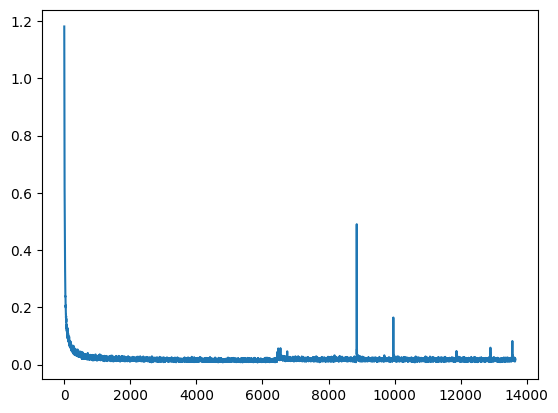

In [ ]:
from matplotlib import pyplot as plt
plt.plot(losses)

## 2.5 The Reverse Step

Now we need to define the reverse step $p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t)$

See that little $_\theta$? That often indicates 'learned parameters' - in this case our unet model! We use our model to predict the noise and then 'undo' the forward noise steps one at a time to go from an image that is pure noise to one that (hopefully) looks like a real image:

In [ ]:
#loading the best model
best_model_params_path = os.path.join(config_dir, 'best_diffusion_params.pt')
model = UNet(n_channels=32).cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device("cpu"))["model"])
optimizer.load_state_dict(torch.load(best_model_params_path, map_location=torch.device("cpu"))["optimizer"])


In [ ]:
def p_xt(xt, noise, t):
################################################################################
    # TODO: complete the code here
    # Write this function based on the formula given in the paper for the reverse step
  alpha_t = gather(alpha, t)
  alpha_bar_t = gather(alpha_bar, t)
  eps_coef = (1 - alpha_t) / (1 - alpha_bar_t) ** .5
  mean = 1 / (alpha_t ** 0.5) * (xt - eps_coef * noise) # Note minus sign
  var = gather(beta, t)
  eps = torch.randn(xt.shape, device=xt.device)
  return mean + (var ** 0.5) * eps
    # End
################################################################################


In [ ]:
x = torch.randn(1, 3, 32, 32).cuda() # Start with random noise
ims = []

################################################################################
    # TODO: complete the code here
    # Write the reverse step loop here

for i in range(n_steps):

  t = torch.tensor(n_steps-i-1, dtype=torch.long).cuda()
  with torch.no_grad():
    pred_noise = model(x.float(), t.unsqueeze(0))
    x = p_xt(x, pred_noise, t.unsqueeze(0))
    if i == 0:
      ims.append(tensor_to_image(x.cpu()))
    if i == 999:
      ims.append(tensor_to_image(x.cpu()))
    if i%(n_steps/10) == 0:
      ims.append(tensor_to_image(x.cpu()))


    # End
################################################################################


In [ ]:
len(ims)

12

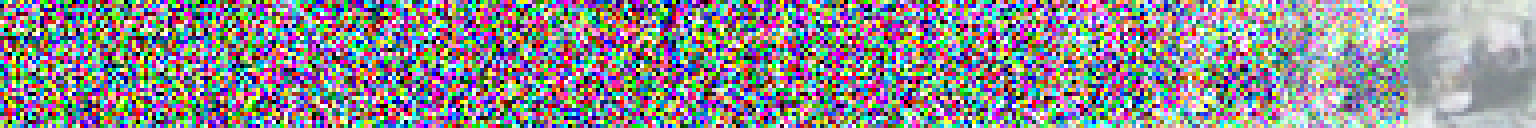

In [ ]:
image = Image.new('RGB', size=(32*len(ims), 32))
for i, im in enumerate(ims):
  image.paste(im, ((i%len(ims))*32, 0))
image.resize((32*4*len(ims), 32*4), Image.NEAREST)

Perfect? No... Oh well, let's try a few more times:

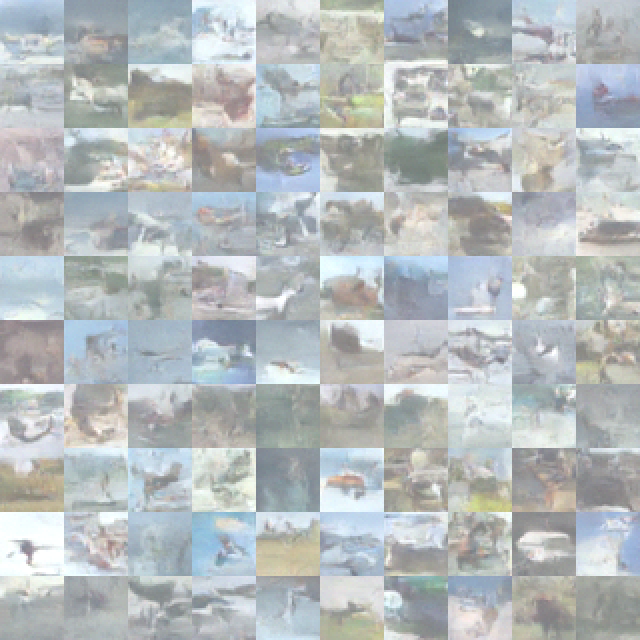

In [ ]:
#@title Make and show 100 examples:
x = torch.randn(100, 3, 32, 32).cuda() # Start with random noise
ims = []
for i in range(n_steps):
  t = torch.tensor(n_steps-i-1, dtype=torch.long).cuda()
  with torch.no_grad():
    pred_noise = model(x.float(), t.unsqueeze(0))
    x = p_xt(x, pred_noise, t.unsqueeze(0))

for i in range(100):
  ims.append(tensor_to_image(x[i].unsqueeze(0).cpu()))

image = Image.new('RGB', size=(32*10, 32*10))
for i, im in enumerate(ims):
  image.paste(im, ((i%10)*32, 32*(i//10)))
image.resize((32*2*10, 32*2*10), Image.NEAREST)



# **Part2: Evaluating the Generated Samples:**

Now we want to evaluate our model. For this, we use the FID score.

First, read [this link](https://github.com/mseitzer/pytorch-fid) to become familiar with this metric and its usage in your code.

Installation

In [ ]:
!pip install pytorch-fid

Generate and Save Samples

In [ ]:
# !rm -r '/content/real_img/'
# !mkdir '/content/real_img/'

In [ ]:
from torchvision.utils import save_image
from torchvision import transforms


# generate 3000 samples
trans = transforms.ToTensor()
j = 0
for k in range(30):
    x = torch.randn(100, 3, 32, 32).cuda() # Start with random noise
    print(j)
    for i in range(n_steps):
      t = torch.tensor(n_steps-i-1, dtype=torch.long).cuda()
      with torch.no_grad():
          pred_noise = model(x.float(), t.unsqueeze(0))
          x = p_xt(x, pred_noise, t.unsqueeze(0))
    for x0 in x:
      save_image(x0.unsqueeze(0).cpu(), "/content/generated_img/" + str(j) + ".png")
      image = cifar10['train'][j]['img']
      save_image(trans(image), "/content/real_img/" + str(j) + ".png")
      j+=1
      # TODO: save the generated sample (x) in a directory
      # See this link: https://pytorch.org/vision/stable/generated/torchvision.utils.save_image.html
      # Be sure to assign a different name to each image!

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


Compute the FID Score

In [ ]:
# TODO: compute the FID score using pytorch-fid package.
# You should have two image directories to compute the score:
# 1- Directory of the original images.
# 2- Directory of the generated images (the directory that you created in the last code cell)

!python -m pytorch_fid /content/real_img /content/generated_img

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:00<00:00, 293MB/s]
100% 60/60 [00:12<00:00,  4.88it/s]
100% 60/60 [00:12<00:00,  4.99it/s]
FID:  138.86430852303909
